In [178]:
import re
import sys
import csv
import nltk
import string
import pickle
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [179]:
from sklearn.svm import SVC
from sklearn import set_config
from nltk.corpus import stopwords
from sklearn.metrics import f1_score
from spellchecker import SpellChecker
from sklearn.pipeline import Pipeline
from nltk.stem import WordNetLemmatizer 
from sklearn.naive_bayes import GaussianNB
from nltk.tokenize import SyllableTokenizer
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer,StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score

In [180]:
stopwords = list(stopwords.words('english'))
rng = 52023

In [181]:
set_config(transform_output='pandas', display='diagram')

# Data - Search Queries

In [182]:
Queries = pd.read_pickle('../data/AllQueries4746.p')
Queries

,query,class
0,US civil war causes,0
1,scooter brands,0
2,scooter brands reliable,0
3,scooter,0
4,scooter cheap,0
...,...,...
4741,House of dreams,1
4742,When did Desmond doss get married,1
4743,H,1
4744,find fact about dog,1


# Query split 90/10

In [183]:
X, y = Queries.drop('class', axis=1), Queries['class']
X_expSet, X_pipSet, y_expSet, y_pipSet = train_test_split(X, y, 
                                                    test_size=0.1, stratify=y,
                                                   random_state=rng)

### 90% - Pipeline train set

In [184]:
# Add the class column back to experiment set
X_expSet['class'] = y_expSet
expSet = X_expSet
expSet.shape

(4271, 2)

### 10% - Pipeline test set

In [185]:
# Add the class column back to pipeline test test
X_pipSet['class'] = y_pipSet
pipSet = X_pipSet
pipSet.shape

(475, 2)

# PART A

In [186]:
queries = expSet.copy()

## 1. Feature Extraction 

### LingFeat

The following *lingFeatExtract* module takes long to run and may not run on mac OS. 

In [188]:
# import lingFeatExtract as lfe

In [ ]:
# lingFeat_pip = Pipeline(steps=[
#     ('LingFeat', FunctionTransformer(lfe.lingFeatExtract)),
    
# ])
# lingFeat_pip

The following *featExtract* module contain functions that extract the following features

- Spelling
- Punctuation and Casing
- Concreteness 

In [1]:
import featExtract as fe 

### Spelling

In [189]:
Spelling_pip = Pipeline(steps=[
    ('Spelling', FunctionTransformer(fe.Spelling)),
    
])
Spelling_pip

Pipeline(steps=[('Spelling',
                 FunctionTransformer(func=<function Spelling at 0x7fae40fa4ca0>))])

### Punctuation and Casing

In [190]:
Punct_Casing_pip = Pipeline(steps=[
    ('Punct_Casing', FunctionTransformer(fe.Punct_Casing)),
    
])
Punct_Casing_pip

Pipeline(steps=[('Punct_Casing',
                 FunctionTransformer(func=<function Punct_Casing at 0x7fae4138d8b0>))])

### Concreteness

In [191]:
absConcFeat_pip = Pipeline(steps=[
    ('absConcFeat', FunctionTransformer(fe.absConcFeat)),
    
])
absConcFeat_pip

Pipeline(steps=[('absConcFeat',
                 FunctionTransformer(func=<function absConcFeat at 0x7fae4138d940>))])

### Feature Extraction Pipeline

We add all feature extraction functions together

In [292]:
feature_extraction= FeatureUnion([
    ('absConc', absConcFeat_pip),
    ('Punct_Casing', Punct_Casing_pip),
    ('Spelling', Spelling_pip),
#     ('LingFeat', lingFeat_pip)
])

feature_extraction

FeatureUnion(transformer_list=[('absConc',
                                Pipeline(steps=[('absConcFeat',
                                                 FunctionTransformer(func=<function absConcFeat at 0x7fae4138d940>))])),
                               ('Punct_Casing',
                                Pipeline(steps=[('Punct_Casing',
                                                 FunctionTransformer(func=<function Punct_Casing at 0x7fae4138d8b0>))])),
                               ('Spelling',
                                Pipeline(steps=[('Spelling',
                                                 FunctionTransformer(func=<function Spelling at 0x7fae40fa4ca0>))]))])

In [193]:
features = feature_extraction.transform(queries)
features.head()

100%|██████████| 4271/4271 [00:00<00:00, 538665.88it/s]


,query,class,ratioAbs,ratioConc,query,class,punct,casing,query,class,kidsError,misspelledCol,oneOffError
3101,SUNY college population,0,0.00,0.666667,SUNY college population,0,0,1,SUNY college population,0,0,1,1
4524,Hfgmhvhjcfhjc facts for kids,1,0.25,0.250000,Hfgmhvhjcfhjc facts for kids,1,0,1,Hfgmhvhjcfhjc facts for kids,1,0,1,-1
4441,robots on star wars,1,0.00,0.500000,robots on star wars,1,0,0,robots on star wars,1,0,0,0
186,venture capital,0,0.50,0.500000,venture capital,0,0,0,venture capital,0,0,0,0
3552,Times Publishing,0,0.00,0.000000,Times Publishing,0,0,1,Times Publishing,0,0,0,0


## 2. Pruning

In the following block of code we do:

- Drop the duplite
- Substitute NaN with 0
- Drop Disco Feature (from lingFeat)
- Drop constant variables


In [194]:
def prune(features):
    
    # 1. Drop duplicated
#     duplicated_columns=features.columns.duplicated()
#     features.loc[:, ~duplicated_columns]
    
    features = features.loc[:,~features.columns.duplicated()]

    
#     # 2. drop Disco features
    discoFeat = ['to_EntiM_C',
            'as_EntiM_C',
            'at_EntiM_C',
            'to_UEnti_C',
            'as_UEnti_C',
            'at_UEnti_C',
            'ra_SSToT_C',
            'ra_SOToT_C',
            'ra_SXToT_C',
            'ra_SNToT_C',
            'ra_OSToT_C',
            'ra_OOToT_C',
            'ra_OXToT_C',
            'ra_ONToT_C',
            'ra_XSToT_C',
            'ra_XOToT_C',
            'ra_XXToT_C',
            'ra_XNToT_C',
            'ra_NSToT_C',
            'ra_NOToT_C',
            'ra_NXToT_C',
            'ra_NNToT_C',
            'LoCohPA_S',
            'LoCohPW_S',
            'LoCohPU_S',
            'LoCoDPA_S',
            'LoCoDPW_S',
            'LoCoDPU_S']
    if all(col in df.columns for col in discoFeat):
        features = features.drop(discoFeat, axis=1, inplace=True)
    
#     # 3. Substitute NaN with 0
    features = features.fillna(0)
    
#     # 4. Drop constant variables 
    constant_columns = []
    for column in features.columns:
        if features[column].nunique() == 1:
            constant_columns.append(column)
    features = pd.DataFrame(features.drop(columns=constant_columns))
    
    return features


In [195]:
features = prune(features)
features.head()

,query,class,ratioAbs,ratioConc,punct,casing,kidsError,misspelledCol,oneOffError
3101,SUNY college population,0,0.00,0.666667,0,1,0,1,1
4524,Hfgmhvhjcfhjc facts for kids,1,0.25,0.250000,0,1,0,1,-1
4441,robots on star wars,1,0.00,0.500000,0,0,0,0,0
186,venture capital,0,0.50,0.500000,0,0,0,0,0
3552,Times Publishing,0,0.00,0.000000,0,1,0,0,0


## 3. Model Selection

In this section we train three different models and identify the best model based on the *Accuracy*

In [196]:
data = features.copy()

### Drop query columns

In [197]:
data.drop(columns = ['query'], inplace = True, axis=1)

### Split data

In [198]:
X = data.drop("class", axis=1)
y = data['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rng, stratify=y)

X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.2, random_state=rng, stratify=y_train)


In [199]:
data['class'].value_counts(normalize = True)

0    0.800047
1    0.199953
Name: class, dtype: float64

In [200]:
X_train.shape, y_train.shape

((2732, 7), (2732,))

In [201]:
X_dev.shape, y_dev.shape

((684, 7), (684,))

In [202]:
y_dev.value_counts(normalize = True)

0    0.799708
1    0.200292
Name: class, dtype: float64

### Tune hyperparameters

In [203]:
# -- -- Dring the code from a separate file

### Train and test models

In [204]:
# Define models with their respective HP
SVM = SVC(C = 0.1, kernel = 'linear')
MLP = MLPClassifier(activation = 'relu', learning_rate = 'constant', alpha = 0.0001, hidden_layer_sizes = (300,), random_state=1)
RF = RandomForestClassifier(criterion = 'entropy', max_depth = None, max_features = 'sqrt', min_samples_split = 2, n_estimators = 500, random_state=rng, n_jobs=-1)
gnb = GaussianNB() # This is added for testing adding and removing models

def modelSelection(model_list):
    results=[]

    for model in model_list:
    
        model_pip =  Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('model', model)
        ])

        model_pip.fit(X_train, y_train)

        model_pred = model_pip.predict(X_test)

        cm = confusion_matrix(y_true = y_test, y_pred = model_pred, labels= model_pip.classes_)

        FP=cm[0,1]
        FN=cm[1,0]
        TP=cm[1,1]
        TN=cm[0,0]

        TPR=TP/(TP+FN)
        TNR=TN/(TN+FP)
        FPR=FP/(FP+TN)
        FNR=FN/(TP+FN)
        acc = accuracy_score(y_true = y_test, y_pred = model_pred)
        f1=f1_score(y_test, model_pred, zero_division=1)
        
        metrics={
            'Model': model.__class__.__name__, # from sklearn
            'Accuracy': acc,
            'TPR': TPR,
            'TNR': TNR,
            'FPR': FPR,
            'FNR': FNR,
            'f1_score': f1
        }
        results.append(metrics)

    res_df = pd.DataFrame(results)

    return res_df    

In [205]:
modelSelection([SVM, MLP, RF, gnb])

,Model,Accuracy,TPR,TNR,FPR,FNR,f1_score
0,SVC,0.803509,0.017544,1.000000,0.000000,0.982456,0.034483
1,MLPClassifier,0.795322,0.052632,0.980994,0.019006,0.947368,0.093264
2,RandomForestClassifier,0.787135,0.099415,0.959064,0.040936,0.900585,0.157407
3,GaussianNB,0.777778,0.081871,0.951754,0.048246,0.918129,0.128440


Note: the best model when the dataset is doesn't include ling feat model os SCV, but according to the experiment done before, RFC performed better 

## 4. Feature importance  

In [206]:
X_cols =  X_train.columns
X_scaled=StandardScaler().fit_transform(X_train[X_cols])

In [207]:
model = RF
model.fit(X_scaled, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=500, n_jobs=-1,
                       random_state=52023)

In [208]:
FeatImp = pd.Series(model.feature_importances_, index=X_cols).sort_values(ascending=False)
FeatImp

ratioAbs         0.360609
ratioConc        0.342856
oneOffError      0.091624
misspelledCol    0.073996
casing           0.068350
punct            0.036255
kidsError        0.026309
dtype: float64

### Feature importance distribution

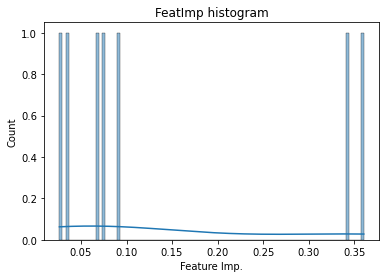

In [209]:
sns.histplot(data = FeatImp, kde = True, bins = 100)
plt.xlabel('Feature Imp.')
plt.title('FeatImp histogram')
plt.show()

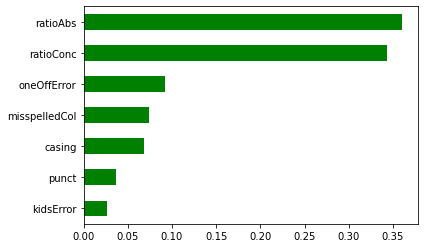

In [210]:
FeatImp.sort_values().plot.barh(color='green')
plt.show()

In [211]:
# mif = FeatImp[FeatImp > 0.003]
mif = FeatImp[FeatImp > 0.10] # for testing
mostImpFeat = pd.DataFrame(mif)
mostImpFeat.reset_index(inplace = True)
mostImpFeat = mostImpFeat.rename(columns={'index':'feat', 0:'values'})
mostImpFeat

,feat,values
0,ratioAbs,0.360609
1,ratioConc,0.342856


# PART B

## 1. Data - Search Query

In [275]:
pipSet.head()

,query,class
1191,consequences building hydroelectric dams could...,0
3802,Information about tigers,1
1570,Russian submarine Kursk sinking,0
1881,SCIENCE GLASS,0
1250,pocono mountains state parks,0


## 2. Feature Extraction 

In [276]:
featuresTest = feature_extraction.transform(pipSet)
featuresTest.head()

100%|██████████| 475/475 [00:00<00:00, 544789.28it/s]


,query,class,ratioAbs,ratioConc,query,class,punct,casing,query,class,kidsError,misspelledCol,oneOffError
1191,consequences building hydroelectric dams could...,0,0.333333,0.444444,consequences building hydroelectric dams could...,0,0,0,consequences building hydroelectric dams could...,0,0,0,0
3802,Information about tigers,1,0.333333,0.000000,Information about tigers,1,0,1,Information about tigers,1,0,0,0
1570,Russian submarine Kursk sinking,0,0.250000,0.250000,Russian submarine Kursk sinking,0,0,1,Russian submarine Kursk sinking,0,0,1,0
1881,SCIENCE GLASS,0,0.000000,0.000000,SCIENCE GLASS,0,0,1,SCIENCE GLASS,0,0,0,0
1250,pocono mountains state parks,0,0.000000,0.250000,pocono mountains state parks,0,0,0,pocono mountains state parks,0,0,1,1


## 3. Pruning

In [277]:
featuresTest = prune(featuresTest)
featuresTest.reset_index(drop=True, inplace=True)
featuresTest.head()

,query,class,ratioAbs,ratioConc,punct,casing,kidsError,misspelledCol,oneOffError
0,consequences building hydroelectric dams could...,0,0.333333,0.444444,0,0,0,0,0
1,Information about tigers,1,0.333333,0.000000,0,1,0,0,0
2,Russian submarine Kursk sinking,0,0.250000,0.250000,0,1,0,1,0
3,SCIENCE GLASS,0,0.000000,0.000000,0,1,0,0,0
4,pocono mountains state parks,0,0.000000,0.250000,0,0,0,1,1


## 4. Select the most important features

In [278]:
newData = featuresTest[mostImpFeat.feat]
newData.reset_index(drop=True, inplace=True)

In [279]:
newData.head()

,ratioAbs,ratioConc
0,0.333333,0.444444
1,0.333333,0.000000
2,0.250000,0.250000
3,0.000000,0.000000
4,0.000000,0.250000


## 5. Prediction

In [280]:
# pred = model_pip.predict(X_test)

## New queries 

In [281]:
dt = featuresTest.copy()

In [282]:
dt.head(2)

,query,class,ratioAbs,ratioConc,punct,casing,kidsError,misspelledCol,oneOffError
0,consequences building hydroelectric dams could...,0,0.333333,0.444444,0,0,0,0,0
1,Information about tigers,1,0.333333,0.000000,0,1,0,0,0


In [283]:
dt.shape

(475, 9)

In [284]:
data2 = featuresTest.copy()
data2.head(2)

,query,class,ratioAbs,ratioConc,punct,casing,kidsError,misspelledCol,oneOffError
0,consequences building hydroelectric dams could...,0,0.333333,0.444444,0,0,0,0,0
1,Information about tigers,1,0.333333,0.000000,0,1,0,0,0


In [285]:
data2.shape

(475, 9)

In [286]:
data2 = data2.drop(['query','class'], axis=1)
data2.shape

(475, 7)

In [288]:
model_pip_test =  Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('model', RF)
    ])

model_pip_test.fit(X_train, y_train)

model_pred_prob_test = model_pip_test.predict_proba(data2)
results = pd.DataFrame(model_pred_prob_test)

In [290]:
results.join(dt[['query','class']])

,0,1,query,class
0,0.851550,0.148450,consequences building hydroelectric dams could...,0
1,0.643278,0.356722,Information about tigers,1
2,0.672545,0.327455,Russian submarine Kursk sinking,0
3,0.653156,0.346844,SCIENCE GLASS,0
4,1.000000,0.000000,pocono mountains state parks,0
...,...,...,...,...
470,0.665073,0.334927,Largest country,1
471,1.000000,0.000000,australia gun crime,0
472,0.643962,0.356038,Marcus Gilmore Edson parents,1
473,0.942350,0.057650,Some of Albert Einstein struggles or hardships,1
